### Example 4 - Unpublished Data: Build a Trade Heuristic

In this example, we'll create a heuristic for estimating individual trade activity in a day of the market.  Some trades
we can infer from changes in the order book between snapshots.  However, this usually doesn't reveal all trades as there is
ambiguity in whether an order was removed because it was canceled, or because it was completely filled \(and hence, a trade\).  In these cases, we'll attempt to estimate which orders were removed because they were completely filled.

This example dives more deeply into analysis than previous examples.  We'll find that the "obvious" choice for
estimating trades does not work very well, and we'll briefly discuss two hypotheses for how to make a better
choice.  We'll show how to perform a basic analysis of these hypotheses, then we'll choose one and show a simple
back test evaluating our strategy.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# We'll use a day of Tritanium trading in The Forge to develop our heuristic.
# This cell loads various static information about Tritanium and The Forge.
#
sde_client = Client.SDE.get()
type_query = "{values: ['Tritanium']}"
region_query = "{values: ['The Forge']}"
type_id = sde_client.Inventory.getTypes(typeName=type_query).result()[0][0]['typeID']
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
compute_date = convert_raw_time(1483228800000) # 2017-01-01 12:00 AM UTC
print("Using type_id=%d, region_id=%d at %s" % (type_id, region_id, str(compute_date)))

Using type_id=34, region_id=10000002 at 2017-01-01 00:00:00


In [3]:
# We'll use book data we downloaded for a previous example and import the data as a Pandas DataFrame.
# If you don't have this data, you can create it by following the instructions towards the end of
# the Jupyter notebook for Example 2.
#
from evekit.marketdata import OrderBook

order_book = OrderBook.get_data_frame(dates=[compute_date], types=[type_id], regions=[region_id], 
                                      config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2017-01-01 00:00:00...done


A quick review of EVE market mechanics tells us that once an order is placed, it can only be changed in the following ways:

* The price can be changed.  Changing price also resets the duration of the order.
* The order can be canceled.  This removes the order from the order book.
* The order can be partially filled.  This reduces volume for the order, but otherwise the order remains in the order book.
* The order can be completely filled.  This removes the order from the order book.

Since a partially filled order is the only unambiguous indication of a trade, let's start buy building our heuristic to catch those events.

In [4]:
# The following function will be our trade inferrer.  It will operate on the order book we loaded into a DataFrame above.
# Note that it is more correct to also include the last snapshot of the previous day into our order book in order to
# detect trades which occur in the first snapshot of the day.  We're ignoring this detail for this example.
#
# The result of this function is a DataFrame containing inferred trades.
#
def infer_trades(order_book):
    inferred_trades = []
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        # We're interested in the set of orders which are present in both snapshots and for which
        # volume changed.
        current_snap = current[1]
        next_snap = next[1]
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        # If we've found any changed orders, then these are trades
        for next_change in changed_orders.index:
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

In [5]:
# Let's test our trade inferrer on the sample book:
trades = infer_trades(order_book)
trades

,buy,location,order_id,price,timestamp,volume
2017-01-01 00:10:00,True,None,4733760768,4.66,2017-01-01 00:10:00,79878800
2017-01-01 00:10:00,True,None,4726038430,4.63,2017-01-01 00:10:00,11351822
2017-01-01 00:10:00,False,60015027,4734004757,4.28,2017-01-01 00:10:00,21111
2017-01-01 00:15:00,True,None,4733760768,4.66,2017-01-01 00:15:00,7239766
2017-01-01 00:20:00,True,None,4733760768,4.66,2017-01-01 00:20:00,2973510
2017-01-01 00:20:00,False,60015027,4734004757,4.28,2017-01-01 00:20:00,1
2017-01-01 00:25:00,True,None,4733760768,4.66,2017-01-01 00:25:00,5063931
2017-01-01 00:25:00,False,60015027,4734004757,4.28,2017-01-01 00:25:00,6528
2017-01-01 00:30:00,True,None,4733760768,4.66,2017-01-01 00:30:00,926
2017-01-01 00:35:00,True,None,4733760768,4.66,2017-01-01 00:35:00,102800


In [6]:
# We know that we may be missing trades which completely fill market orders.
# We can get a sense as to how far off we are by comparing the the total volume of
# inferred trades versus the market history for the same day.
from evekit.marketdata import MarketHistory
market_history = MarketHistory.get_data_frame(dates=[compute_date], types=[type_id], regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2017-01-01 00:00:00...done


In [7]:
# Let's see how we did...
missing_volume = market_history.ix[compute_date].volume - trades.volume.sum()
missing_volume

7907496573

In [8]:
# We're off quite a bit.  This is only one day of data, so we shouldn't draw too many conclussions,
# but let's take a look at the relative volumes.
trades.volume.sum() / market_history.ix[compute_date].volume * 100

36.854116241480703

In [9]:
# So we can recover about 1/3 of the daily volume from partial fills for this day.  That leaves us
# to estimate complete fills, but it also tells us this is an important estimate as the majority
# of this day's trading volume came from complete fills.
#
# We'll start with a naive approach, where we assume every order present in one snapshot, but removed
# in the next is a complete fill.  We know this is wrong, but maybe the estimate is close enough
# that we can ignore including a few cancels in our estimate.  Since some trades will now be guesses
# (instead of provable partial fills), we'll add a new "actual" field to the results so we can 
# distinguish which trades we're estimating.
#
# Here's the new version of our heuristic:

def infer_trades_2(order_book):
    inferred_trades = []
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # First, look for orders present in both snapshots but have their volume changed
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'actual': True,
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
        # Second, look for orders which are removed between snapshots.  We'll treat these
        # as completely filled orders for now.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            location = next_line.location_id
            if next_line.buy and next_line.order_range != 'station':
                # See above
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'actual': False,
                'buy': next_line.buy, 
                'order_id': order_id, 
                'price': next_line.buy,
                'volume': next_line.volume, 
                'location': str(location)})                
    # Return result
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

In [10]:
# Let's see how are inferred volume compares now.
#
trades_2 = infer_trades_2(order_book)
missing_volume_2 = market_history.ix[compute_date].volume - trades_2.volume.sum()
print("total orders: %d  inferred orders: %d  missing volume: %d" % (len(trades_2), 
                                                                     len(trades_2[trades_2.actual == False]),
                                                                     missing_volume_2))

total orders: 5054  inferred orders: 4437  missing volume: -408445073685


In [11]:
# Now we've overshot by a significant amount!  Specifically:
#
trades_2.volume.sum() / market_history.ix[compute_date].volume * 100

3361.6675715950209

In [12]:
# That's well over a 3000% overshoot!  Simply assuming every missing order is a complete fill 
# is quite bad.  This indicates that a substantial amount of order volume removed from 
# the book is in fact due to cancels (or expired orders), so we'll need to do a bit better.
#
# A deeper analysis of trade estimation is beyond the scope of this example.  So for now, we'll
# consider two hypotheses to discover which trades are likely complete fills, and which trades are
# likely cancels or expires.  We'll show how to investigate these hypotheses, then we'll set up
# a simple back test to see if one of our hypotheses holds up over a longer range of data.
#
# Our first hypothesis is that removed orders closer to the current top of book (best bid and ask) are
# most likely fills instead of cancels.  This isn't perfect because the top of book for buys
# depends on the seller's location, but it seems like a reasonable estimate.  Based on a given
# threshold, say N orders away from the current top of book, we can test how many orders would
# fall outside the threshold.
#
# The following function returns the top N buy orders:
def top_n_buy(book, n):
    return set(book[book.buy == True][:n].order_id)
#
# For the top N sell orders we can do better if we know the location since a sell order is always
# filled at the location of the order.  That is, the top N for sells should be restricted to
# the top N sell orders at a given location.  Here's how to do that:
def top_n_sell(book, n, location):
    return set(pd.merge(book[book.buy == True], book[book.location_id == location])[:n].order_id)
#
# Putting all this together, we can write a simple algorithm to count the orders and volume
# that would be included if we treat top N removed orders as complete fills.
def include_top_n(order_book, threshold):
    # This will count how many orders and volume we'd include with this approach
    include_count = 0
    include_volume = 0
    # Proceed snap by snap as before
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # Iterate over removed orders
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            # If the removed order is a buy, get the set of buys.  Otherwise, extract
            # the location of the missing order and get the set of sells.
            order_info = current_snap[current_snap.order_id == order_id].ix[current[0]]
            if order_info.buy:
                top_n = top_n_buy(current_snap, threshold)
            else:
                location = order_info.location_id
                top_n = top_n_sell(current_snap, threshold, location)
            if order_id in top_n:
                # It's in the top N, we'll treat it as a complete fill
                include_count += 1
                include_volume += order_info.volume
    # Return result
    return (include_count, include_volume)

In [13]:
# Now let's see how well this works in accounting for fill volume.  We'll report several stats:
#
# 1. Top N threshold
# 2. Count of fills captured this way
# 3. Volume of fills captured this way
# 4. Number of orders left after subtracting partial fills and top N fills
# 5. Amount of volume left after subtracing partial fills and top N fills
#
# We want these last two stats to be close to zero without going under.
#
partial_count = len(trades_2[trades_2.actual == True])
partial_volume = trades_2[trades_2.actual == True].volume.sum()
order_count = market_history.ix[compute_date].order_count
order_volume = market_history.ix[compute_date].volume
for i in range(1,11):
    count, volume = include_top_n(order_book, i)
    print("N: %d  count: %d  volume: %d  orders_rem: %d  volume_rem: %d" % \
          (i, count, volume, order_count - partial_count - count, order_volume - partial_volume - volume))

N: 1  count: 9  volume: 52349414  orders_rem: 2197  volume_rem: 7855147159
N: 2  count: 12  volume: 170092994  orders_rem: 2194  volume_rem: 7737403579
N: 3  count: 20  volume: 776429478  orders_rem: 2186  volume_rem: 7131067095
N: 4  count: 38  volume: 1109758755  orders_rem: 2168  volume_rem: 6797737818
N: 5  count: 57  volume: 1775571080  orders_rem: 2149  volume_rem: 6131925493
N: 6  count: 80  volume: 3117031648  orders_rem: 2126  volume_rem: 4790464925
N: 7  count: 100  volume: 7103722588  orders_rem: 2106  volume_rem: 803773985
N: 8  count: 112  volume: 11057165654  orders_rem: 2094  volume_rem: -3149669081
N: 9  count: 122  volume: 14062254206  orders_rem: 2084  volume_rem: -6154757633
N: 10  count: 126  volume: 15545408847  orders_rem: 2080  volume_rem: -7637912274


In [14]:
# The results show we can get much closer matching volume with this heuristic, but not very close 
# in order count.  This suggests that we apply a very conservative choice here, perhaps including 
# every removed order in the top 3 on either side (e.g. buy or sell) as a valid complete fill.
#
# For our second hypothesis, let's look at removed order volume as a fraction of total volume for
# the day.  Our intuition is that large orders should be relatively rare.  In fact, we'd expect
# average per-order volume based on historical data as follows:
hist_avg_volume = order_volume / order_count
hist_avg_volume_percent = 1 / order_count * 100
print("historic avg volume: %d  historic avg volume %%: %.02f" % (hist_avg_volume, hist_avg_volume_percent))

historic avg volume: 4435913  historic avg volume %: 0.04


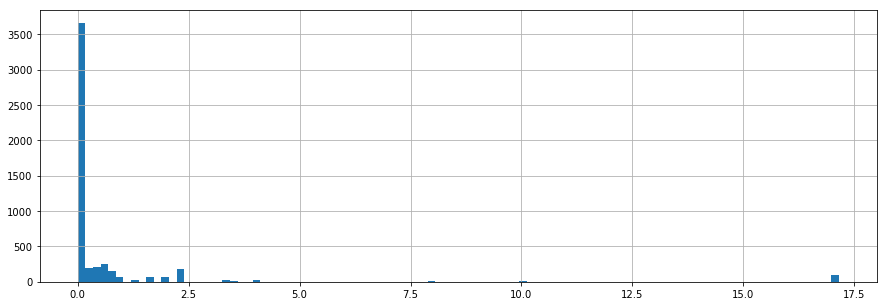

In [15]:
# So an average order is roughly 4m and accounts for about 0.04% of the total volume.  Let's look at
# a histogram of our original orders to visualize removed order volume as a percentage of total volume
# (each bar is about 0.16% of total volume in this figure).
(trades_2.volume / order_volume * 100).hist(bins=100, figsize=[15,5])

In [16]:
# In general, our inferred orders look reasonable but there are clear outliers.  Also, there is bunching around
# expected average volume of 0.04% (the first bar is orders less than 0.16% in volume).  There are still too
# many orders in this first grouping (according to historic data), but this suggests we might be able to treat
# larger volumes as cancels instead of fills.  As in the previous example, we can try various thresholds and 
# compute the resulting volume.  The following function will help us evaluate this heuristic.
#
# Threshold is in volume.  We'll talk about why we use volume instead of % volume below.
#
def eliminate_large_orders(order_book, threshold):
    # This will count how many orders and volume we'd include with this approach
    include_count = 0
    include_volume = 0
    # Proceed snap by snap as before
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # Iterate over removed orders
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            # If the volume of a removed order does not exceed the threshold, then keep it.
            order_info = current_snap[current_snap.order_id == order_id].ix[current[0]]
            if order_info.volume <= threshold:
                # This is an order we would consider to be a completed fill
                include_count += 1
                include_volume += order_info.volume
    # Return result
    return (include_count, include_volume)

In [17]:
# We report the same statistics as above for comparison.
#
volume_step = hist_avg_volume / 2
for i in range(1,21):
    count, volume = eliminate_large_orders(order_book, i * volume_step)
    print("i: %d  threshold: %d  count: %d  volume: %d  orders_rem: %d  vol_rem: %d" % \
          (i, i * volume_step, count, volume, order_count - partial_count - count, order_volume - partial_volume - volume))

i: 1  threshold: 2217956  count: 2259  volume: 1330730659  orders_rem: -53  vol_rem: 6576765914
i: 2  threshold: 4435913  count: 2601  volume: 2436149238  orders_rem: -395  vol_rem: 5471347335
i: 3  threshold: 6653870  count: 2744  volume: 3196369570  orders_rem: -538  vol_rem: 4711127003
i: 4  threshold: 8871827  count: 2892  volume: 4315363970  orders_rem: -686  vol_rem: 3592132603
i: 5  threshold: 11089784  count: 2910  volume: 4492364979  orders_rem: -704  vol_rem: 3415131594
i: 6  threshold: 13307741  count: 2963  volume: 5123135517  orders_rem: -757  vol_rem: 2784361056
i: 7  threshold: 15525697  count: 2985  volume: 5458147362  orders_rem: -779  vol_rem: 2449349211
i: 8  threshold: 17743654  count: 3018  volume: 5997314612  orders_rem: -812  vol_rem: 1910181961
i: 9  threshold: 19961611  count: 3023  volume: 6090528451  orders_rem: -817  vol_rem: 1816968122
i: 10  threshold: 22179568  count: 3088  volume: 7397489109  orders_rem: -882  vol_rem: 510007464
i: 11  threshold: 2439752

In [18]:
# Using the average historic per-order volume size overshoots the order count by about 10%
# but undershoots historic volume by about 43%.  Why did we use raw volume as a threshold instead
# of a percent of total volume?  We did this because we'd like to be able to apply our heuristic
# on days where total volume may not yet be known (for example, the current day).  On such days,
# we can provide an estimate of the average per order volume and use that as a threshold.
#
# At this point, neither heuristic seems very promising and further analysis is likely required.
# But for the sake of finishing this example, let's use the average historic volume heuristic to
# filter complete fills and let's arbitrarily choose to use five times the average historic volume 
# as a threshold for eliminating trades.  Based on the last run of this heuristic, this will get 
# us close to capturing all volume, but will overshoot orders by about 30%.  However, these orders 
# are all relatively small (about 0.2% each of total volume), so the overshoot may not be significant.
#
# To test the validity of our algorithm, we'll code up the new version and then evaluate it against 
# a month of historic data.  This is a relatively short backtest, but large enough for demonstration 
# purposes.
#
# Here's the final version of our trade inference algorithm:
#
def infer_trades_3(order_book, volume_threshold):
    inferred_trades = []
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # First, look for orders present in both snapshots but have their volume changed
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            # Create the trade object
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'actual': True,
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
        # Second, look for orders which are removed between snapshots.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            # If the volume of a removed order does not exceed the threshold, then keep it.
            if next_line.volume <= volume_threshold:
                location = next_line.location_id
                if next_line.buy and next_line.order_range != 'station':
                    # See above
                    location = None
                inferred_trades.append({
                    'timestamp': next[0],
                    'actual': False,
                    'buy': next_line.buy, 
                    'order_id': order_id, 
                    'price': next_line.buy,
                    'volume': next_line.volume, 
                    'location': str(location)})                
    # Return result
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

We'll now move to backtesting our strategy.  Since we want to be able to infer trades
on a day for which we don't yet have historic data (e.g. the current day), we'll set
the volume threshold to be the five day moving average of the average daily volume
\(i.e. volume / orders\).  We need historic book and market history for our backtest,
with slightly more market history so that we can compute the moving average for
the first day of our backtest.

The next two cells are for downloading market data if you don't already have it local.
We suggest you do this on a fast connection.  If, instead, you want to use live data, then 
remove the `local_storage` option from the order book and market data loaders after
the next two cells.

In [19]:
#
# WARNING: this cell will take some time to evaluate if your connection is slow
#
# You can evaluate this cell to download a month of data from compute_date
#
from evekit.online.Download import download_order_book_range
date_range = pd.date_range(compute_date - datetime.timedelta(days=30), compute_date)
download_order_book_range(date_range, ".", types=[type_id], regions=[region_id], config={'verbose': True, 'tree': True})

In [20]:
#
# WARNING: this cell will take some time to evaluate if your connection is slow
#
# We need historic market summaries as well, this cell will download those if you don't have them already.
# Note that we extend the range by five days so we can start the backtest on 2016-12-02.
#
from evekit.online.Download import download_market_history_range
history_date_range = pd.date_range(compute_date - datetime.timedelta(days=35), compute_date)
download_market_history_range(history_date_range, ".", dict(skip_missing=True, tree=True, verbose=True))

In [21]:
# Reload market history to get the complete range.
market_history = MarketHistory.get_data_frame(dates=history_date_range, types=[type_id], regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-11-27 00:00:00...done
Retrieving 2016-11-28 00:00:00...done
Retrieving 2016-11-29 00:00:00...done
Retrieving 2016-11-30 00:00:00...done
Retrieving 2016-12-01 00:00:00...done
Retrieving 2016-12-02 00:00:00...done
Retrieving 2016-12-03 00:00:00...done
Retrieving 2016-12-04 00:00:00...done
Retrieving 2016-12-05 00:00:00...done
Retrieving 2016-12-06 00:00:00...done
Retrieving 2016-12-07 00:00:00...done
Retrieving 2016-12-08 00:00:00...done
Retrieving 2016-12-09 00:00:00...done
Retrieving 2016-12-10 00:00:00...done
Retrieving 2016-12-11 00:00:00...done
Retrieving 2016-12-12 00:00:00...done
Retrieving 2016-12-13 00:00:00...done
Retrieving 2016-12-14 00:00:00...done
Retrieving 2016-12-15 00:00:00...done
Retrieving 2016-12-16 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-18 00:00:00...done
Retrieving 2016-12-19 00:00:00...done
Retrieving 2016-12-20 00:00:00...done
Retrieving 2016-12-21 00:00:00...done
Retrieving 2016-12-22 00:00:00...done
Retrieving 2

In [22]:
# Now run the backtest, storing the results in a DataFrame for further analysis
volume_thresh_series = (market_history.volume / market_history.order_count).rolling(window=5, center=False).mean()
test_results = []
volume_multiplier = 5
for test_date in date_range:
    test_book = OrderBook.get_data_frame(dates=[test_date], types=[type_id], regions=[region_id], 
                                         config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))
    test_trades = infer_trades_3(test_book, volume_thresh_series.ix[test_date] * volume_multiplier)
    test_results.append({
        'date': test_date,
        'trade_count': len(test_trades),
        'trade_volume': test_trades.volume.sum(),
        'historic_count': market_history.ix[test_date].order_count,
        'historic_volume': market_history.ix[test_date].volume
    })
test_results_df = DataFrame(test_results, index=[x['date'] for x in test_results])
test_results_df

Retrieving 2016-12-02 00:00:00...done
Retrieving 2016-12-03 00:00:00...done
Retrieving 2016-12-04 00:00:00...done
Retrieving 2016-12-05 00:00:00...done
Retrieving 2016-12-06 00:00:00...done
Retrieving 2016-12-07 00:00:00...done
Retrieving 2016-12-08 00:00:00...done
Retrieving 2016-12-09 00:00:00...done
Retrieving 2016-12-10 00:00:00...done
Retrieving 2016-12-11 00:00:00...done
Retrieving 2016-12-12 00:00:00...done
Retrieving 2016-12-13 00:00:00...done
Retrieving 2016-12-14 00:00:00...done
Retrieving 2016-12-15 00:00:00...done
Retrieving 2016-12-16 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-18 00:00:00...done
Retrieving 2016-12-19 00:00:00...done
Retrieving 2016-12-20 00:00:00...done
Retrieving 2016-12-21 00:00:00...done
Retrieving 2016-12-22 00:00:00...done
Retrieving 2016-12-23 00:00:00...done
Retrieving 2016-12-24 00:00:00...done
Retrieving 2016-12-25 00:00:00...done
Retrieving 2016-12-26 00:00:00...done
Retrieving 2016-12-27 00:00:00...done
Retrieving 2

,date,historic_count,historic_volume,trade_count,trade_volume
2016-12-02,2016-12-02,3631,18556468661,3875,15871094414
2016-12-03,2016-12-03,3987,23656393057,3841,17858851285
2016-12-04,2016-12-04,4405,23724867157,3950,20288500125
2016-12-05,2016-12-05,3534,19141332549,4031,22695710900
2016-12-06,2016-12-06,3677,15651461252,4158,16151976401
2016-12-07,2016-12-07,3417,12717852113,4642,13751048395
2016-12-08,2016-12-08,3425,20708633301,4310,19270249060
2016-12-09,2016-12-09,3456,12928838084,3857,14263443143
2016-12-10,2016-12-10,4072,26555598594,3777,16272409829
2016-12-11,2016-12-11,4197,14006696844,3628,11705905367


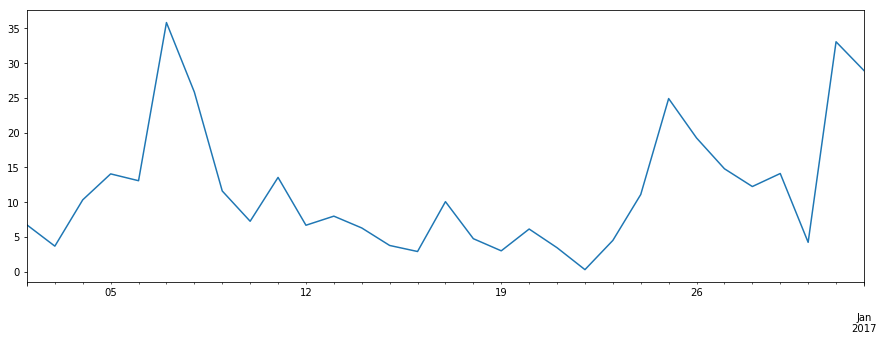

In [23]:
# We can graph the results in various ways to analyze performance.  Here's a graph
# of the trade differential as a percent of historic order count.
#
((test_results_df.historic_count - test_results_df.trade_count).abs()\
 /test_results_df.historic_count * 100).plot(figsize=[15,5])

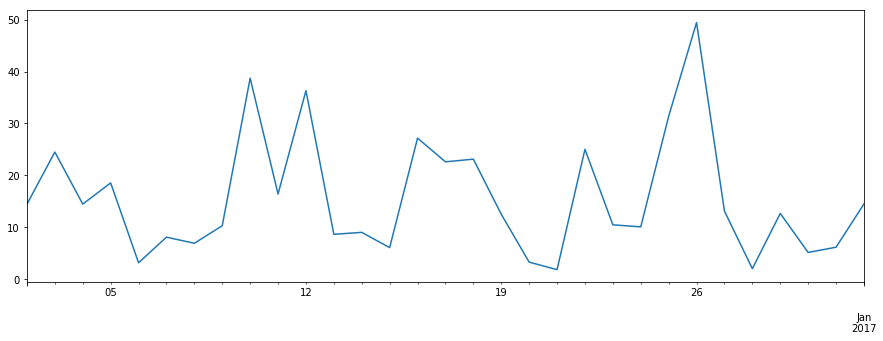

In [24]:
# Order count differences show clear outliers, but perhaps this is not surprising given our initial analysis.
# We can view the same comparison for volume differential as well:
#
((test_results_df.historic_volume - test_results_df.trade_volume).abs()\
 / test_results_df.historic_volume * 100).plot(figsize=[15,5])

This comparison shows a much wider differential, so perhaps we need to fine tune our heuristic.
We leave that as an exercise for the reader.

The EveKit libraries do not include any explcit support for trade analysis such as we described above.
The highly heuristic nature of this analsyis makes it difficult to provide a standard offering.
As we'll see in later chapters, the basic analysis above can be adapted to the specific needs of
a particular trading strategy.